# Import

In [1]:
# # catboost, xgboost, lightgbm 앙상블 모델 -> 미완
# # 2phase에서는 catboost 사용
# ! pip install xgboost
# ! pip install lightgbm
! pip install catboost
! pip install catboost
! pip install optuna
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Catboost model
from catboost import CatBoostClassifier, Pool

# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import itertools

# Seed 42로 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42)

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

/home/juneyonglee/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# 데이터 불러오기

In [3]:
ROOT_DIR = "data"
RANDOM_STATE = 110
pd.set_option('display.max_columns', None)
# Load data
train_df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
# 민감도 분석 행렬 -> 미리 feature 민감도 gpu로 분석한 결과 csv 추가
# RTX 3090*2 24시간 넘어감. 기존 제출환경인 cpu환경에서 안된다고 판단  
sensitivity_analysis_results_df = pd.read_csv(os.path.join(ROOT_DIR, "sensitivity_analysis_results.csv"))

### Equipment 칼럼 패턴 파악 및 레이블링

In [4]:
# 기존 데이터프레임에서 'Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2' 칼럼 추출
equipment_columns = ['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2']
df_equipment = train_df[equipment_columns]

# 새로운 데이터프레임 생성
df_new = pd.DataFrame(df_equipment)

# 결과 출력
df_new

,Equipment_Dam,Equipment_AutoClave,Equipment_Fill1,Equipment_Fill2
0,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
1,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
2,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
3,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
4,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
...,...,...,...,...
40501,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
40502,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2
40503,Dam dispenser #1,Auto Clave Out,Fill1 dispenser #1,Fill2 dispenser #1
40504,Dam dispenser #2,Auto Clave Out,Fill1 dispenser #2,Fill2 dispenser #2


In [5]:
# 주어진 패턴 정의
pattern1 = ['Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1']
pattern2 = ['Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2']

# 주어진 패턴과 일치하는 행 찾기
df_new['Matches_Pattern'] = df_new.apply(lambda row: (row.values.tolist() == pattern1) or (row.values.tolist() == pattern2), axis=1)

# 주어진 패턴과 일치하지 않는 행 출력
non_matching_rows = df_new[~df_new['Matches_Pattern']]

print("주어진 패턴과 일치하지 않는 행:")
print(non_matching_rows)

주어진 패턴과 일치하지 않는 행:
          Equipment_Dam Equipment_AutoClave     Equipment_Fill1  \
3364   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #2   
4787   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5102   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5561   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
5922   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
6560   Dam dispenser #2      Auto Clave Out  Fill1 dispenser #2   
6563   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #2   
9724   Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
10007  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
13028  Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
14452  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
15612  Dam dispenser #2      Auto Clave Out  Fill1 dispenser #1   
17078  Dam dispenser #1      Auto Clave Out  Fill1 dispenser #1   
17503  Dam dispenser #1      Auto Clave Out

In [6]:
import pandas as pd
import itertools

# equipment 칼럼 조합 레이블링
# 가능한 조합 생성
equipment_dam = ['Dam dispenser #1', 'Dam dispenser #2']
equipment_autoclave = ['Auto Clave Out']
equipment_fill1 = ['Fill1 dispenser #1', 'Fill1 dispenser #2']
equipment_fill2 = ['Fill2 dispenser #1', 'Fill2 dispenser #2']

combinations = list(itertools.product(equipment_dam, equipment_autoclave, equipment_fill1, equipment_fill2))

# 조합에 고유 레이블 할당
combination_labels = {comb: idx for idx, comb in enumerate(combinations)}

# 레이블링 함수
def label_row(row):
    comb = (row['Equipment_Dam'], row['Equipment_AutoClave'], row['Equipment_Fill1'], row['Equipment_Fill2'])
    return combination_labels.get(comb, -1)  # 조합이 없을 경우 -1 반환

# 데이터프레임에 레이블 컬럼 추가
train_df['Equipment'] = train_df.apply(label_row, axis=1)
test_df['Equipment'] = test_df.apply(label_row, axis=1)

# Equipment_Label을 맨 앞에 추가
train_df.insert(0, 'Equipment', train_df.pop('Equipment'))
test_df.insert(0, 'Equipment', test_df.pop('Equipment'))

# 조합 레이블 출력 함수
def print_combination_labels(combination_labels):
    for comb, label in combination_labels.items():
        print(f"Combination: {comb} -> Label: {label}")

# 결과 출력
print_combination_labels(combination_labels)
print(train_df['Equipment'].value_counts())


Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1') -> Label: 0
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #2') -> Label: 1
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #1') -> Label: 2
Combination: ('Dam dispenser #1', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2') -> Label: 3
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #1') -> Label: 4
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #1', 'Fill2 dispenser #2') -> Label: 5
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #1') -> Label: 6
Combination: ('Dam dispenser #2', 'Auto Clave Out', 'Fill1 dispenser #2', 'Fill2 dispenser #2') -> Label: 7
Equipment
0    25011
7    15461
3       13
4       10
1        6
6        5
Name: count, dtype: int64


/tmp/ipykernel_2248821/3417841736.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.insert(0, 'Equipment', train_df.pop('Equipment'))
/tmp/ipykernel_2248821/3417841736.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df.insert(0, 'Equipment', test_df.pop('Equipment'))


### 범주형 칼럼 통합 

In [7]:
# 중복되는 칼럼을 삭제후 통합한 칼럼 이름 'Model.Suffix_Dam' 변경
train_df = train_df.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
train_df = train_df.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

test_df = test_df.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_df = test_df.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# workorder 위와 같이 진행

train_df = train_df.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
train_df = train_df.rename(columns={'Workorder_Dam': 'Workorder'})

test_df = test_df.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_df = test_df.rename(columns={'Workorder_Dam': 'Workorder'})

# 이름 이상한 부분 발견 및 변경
train_df = train_df.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_df = test_df.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [8]:
# 16:1 의 비로 클래스 불균형 파악
train_df['target'].value_counts()


target
Normal      38156
AbNormal     2350
Name: count, dtype: int64

In [9]:
# 칼럼에서 모두 0인 칼럼이 있는지 확인
train_df.isnull().sum()

Equipment                            0
Wip Line_Dam                         0
Process Desc._Dam                    0
Equipment_Dam                        0
Model.Suffix                         0
                                 ...  
Receip No Judge Value_Fill2      40506
WorkMode Collect Result_Fill2        0
WorkMode Unit Time_Fill2         40506
WorkMode Judge Value_Fill2       40506
target                               0
Length: 459, dtype: int64

### Model.Suffix를 기준으로 Normal AbNormal 비율 EDA

In [10]:
# 모델 서픽스 리스트 정의
model_suffix_values = ['AJX75334501', 'AJX75334502', 'AJX75334503',
                       'AJX75334505', 'AJX75334506', 'AJX75334507', 'AJX75334508']

# 대상 칼럼 정의
# model_suffix_columns = ['Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2']
model_suffix_columns = ['Model.Suffix']

# 'model_suffix_values'를 기준으로 'target' 값의 개수 합산
result = {value: {'AbNormal': 0, 'Normal': 0} for value in model_suffix_values}

for column in model_suffix_columns:
    for value in model_suffix_values:
        count_abnormal = train_df[(train_df[column] == value) & (train_df['target'] == 'AbNormal')].shape[0]
        count_normal = train_df[(train_df[column] == value) & (train_df['target'] == 'Normal')].shape[0]
        result[value]['AbNormal'] += count_abnormal
        result[value]['Normal'] += count_normal

# 결과 출력 및 비율 계산
for value in model_suffix_values:
    abnormal_count = result[value]['AbNormal']
    normal_count = result[value]['Normal']
    total_count = abnormal_count + normal_count
    abnormal_ratio = abnormal_count / total_count if total_count != 0 else 0
    normal_ratio = normal_count / total_count if total_count != 0 else 0
    print(f"Value: {value}, AbNormal: {abnormal_count}, Normal: {normal_count}, AbNormal Ratio: {abnormal_ratio:.2f}, Normal Ratio: {normal_ratio:.2f}")

Value: AJX75334501, AbNormal: 1918, Normal: 31902, AbNormal Ratio: 0.06, Normal Ratio: 0.94
Value: AJX75334502, AbNormal: 230, Normal: 3160, AbNormal Ratio: 0.07, Normal Ratio: 0.93
Value: AJX75334503, AbNormal: 44, Normal: 118, AbNormal Ratio: 0.27, Normal Ratio: 0.73
Value: AJX75334505, AbNormal: 130, Normal: 2505, AbNormal Ratio: 0.05, Normal Ratio: 0.95
Value: AJX75334506, AbNormal: 8, Normal: 121, AbNormal Ratio: 0.06, Normal Ratio: 0.94
Value: AJX75334507, AbNormal: 18, Normal: 292, AbNormal Ratio: 0.06, Normal Ratio: 0.94
Value: AJX75334508, AbNormal: 2, Normal: 58, AbNormal Ratio: 0.03, Normal Ratio: 0.97


# 데이터 전처리

In [11]:
# 결정트리에서 상수취급되는 불필요한 칼럼 제거
def drop_columns_if_exist(df, columns_to_drop):
    for column in columns_to_drop:
        if column in df.columns:
            df = df.drop(column, axis=1)
            print(f"Column '{column}' dropped.")
        else:
            print(f"Column '{column}' does not exist.")
    return df

train_df = drop_columns_if_exist(train_df, {
    'Wip Line_Dam', 'Wip Line_AutoClave', 'Wip Line_Fill1', 'Wip Line_Fill2',
    'Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2',
    'Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2',
    'Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2',
    'Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2',
})

test_df = drop_columns_if_exist(test_df, {
    'Wip Line_Dam','Wip Line_AutoClave', 'Wip Line_Fill1', 'Wip Line_Fill2',
    'Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2',
    'Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2',
    'Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2',
    'Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2',
})




Column 'Insp Judge Code_Dam' dropped.
Column 'Process Desc._AutoClave' dropped.
Column 'Insp. Seq No._Dam' dropped.
Column 'Process Desc._Fill2' dropped.
Column 'Process Desc._Dam' dropped.
Column 'Wip Line_Fill1' dropped.
Column 'Equipment_AutoClave' dropped.
Column 'Wip Line_Fill2' dropped.
Column 'Wip Line_Dam' dropped.
Column 'Wip Line_AutoClave' dropped.
Column 'Insp. Seq No._AutoClave' dropped.
Column 'Insp Judge Code_Fill1' dropped.
Column 'Equipment_Dam' dropped.
Column 'Equipment_Fill1' dropped.
Column 'Insp Judge Code_Fill2' dropped.
Column 'Equipment_Fill2' dropped.
Column 'Process Desc._Fill1' dropped.
Column 'Insp. Seq No._Fill1' dropped.
Column 'Insp. Seq No._Fill2' dropped.
Column 'Insp Judge Code_AutoClave' dropped.
Column 'Insp Judge Code_Dam' dropped.
Column 'Process Desc._AutoClave' dropped.
Column 'Insp. Seq No._Dam' dropped.
Column 'Process Desc._Fill2' dropped.
Column 'Process Desc._Dam' dropped.
Column 'Wip Line_Fill1' dropped.
Column 'Equipment_AutoClave' droppe

In [12]:
# NaN값은 모두 0으로 채우기
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [13]:
# Set ID 지우기
test_df = test_df.drop(columns=['Set ID'])


In [14]:
# 데이터 내 "OK", "NG" 등 문자열 데이터 찾기
except_columns = {
    'Equipment', 'Model.Suffix', 'Workorder', 'target',
    # 'WorkMode',
    # 'PalletID',
    # 'Production Qty',
    }
def find_string_value(df):
    string_columns = []

    for col in df.columns:
        if df[col].apply(lambda x : isinstance(x, str)).any() and col not in except_columns:
            string_columns.append(col)
            print(f"Column '{col}' contains string values")

    for col in string_columns:
        print(df[col].value_counts())

    return string_columns

# "OK" -> 1, "NG" -> 0으로 인코딩
def incording_string_value(df, string_columns):
    for col in string_columns:
        df[col] = df[col].apply(lambda x: 1 if x == "OK" else 0 if x == "NG" else x)
        df[col] = df[col].astype(float)

train_df_string_columns = find_string_value(train_df)
incording_string_value(train_df, train_df_string_columns)

test_df_string_columns = find_string_value(test_df)
incording_string_value(test_df, test_df_string_columns)




Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam' contains string values


Column '1st Pressure Judge Value_AutoClave' contains string values
Column '2nd Pressure Judge Value_AutoClave' contains string values
Column '3rd Pressure Judge Value_AutoClave' contains string values
Column 'Chamber Temp. Judge Value_AutoClave' contains string values
Column 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave' contains string values
Column 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2' contains string values
Column 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2' contains string values
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
0        12766
OK       11293
549       7271
162.4     3580
550       2398
550.3     1909
549.5     1263
548.5       26
Name: count, dtype: int64
HEA

### 유의미한 칼럼추가

### 공정데이터에서 총 4개의 대분류가 있음. Dam, AutoClave, Fill1, Fill2가 있음. 

In [37]:

# 총 4개의 대분류에서 AutoClave feature가 중요한 역할을 하고 있다고 파악
def process_dataframe(df):
    new_columns = {}
    # AutoClave
    # 평균 압력 및 온도 계산
    df['Average Pressure'] = df[
        [
            '1st Pressure Collect Result_AutoClave',
            '2nd Pressure Collect Result_AutoClave',
            '3rd Pressure Collect Result_AutoClave'
        ]
    ].astype(float).mean(axis=1)

    # 압력 및 온도 변동 계산
    df['Pressure Variation'] = df[
        [
            '1st Pressure Collect Result_AutoClave',
            '2nd Pressure Collect Result_AutoClave',
            '3rd Pressure Collect Result_AutoClave'
        ]
    ].astype(float).std(axis=1)

    # 압력 및 온도 변화율 계산
    df['Pressure Change Rate (Stage 1)'] = df['1st Pressure Collect Result_AutoClave'].astype(float) / df['1st Pressure Unit Time_AutoClave'].astype(float)
    df['Pressure Change Rate (Stage 2)'] = df['2nd Pressure Collect Result_AutoClave'].astype(float) / df['2nd Pressure Unit Time_AutoClave'].astype(float)
    df['Pressure Change Rate (Stage 3)'] = df['3rd Pressure Collect Result_AutoClave'].astype(float) / df['3rd Pressure Unit Time_AutoClave'].astype(float)

    # 온도 변화에 대한 로그 변환
    df['LOG_TEMP_CHANGE_RATE_AutoClave'] = np.log(df['Chamber Temp. Collect Result_AutoClave'].astype(float) + 1) / df['Chamber Temp. Unit Time_AutoClave'].astype(float)
    
    
    df['Std_Dam_X'] = df[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                                    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                                    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam']].astype(float).std(axis=1)

    df['Std_Fill1_X'] = df[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']].astype(float).std(axis=1)

    df['Std_Fill2_X'] = df[['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2']].astype(float).std(axis=1)

    df['Std_Dam_Y'] = df[['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']].astype(float).std(axis=1)

    df['Std_Fill1_Y'] = df[['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']].astype(float).std(axis=1)

    df['Std_Fill2_Y'] = df[['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2']].astype(float).std(axis=1)

    df['Std_Dam_Z'] = df[['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']].astype(float).std(axis=1)

    df['Std_Fill1_Z'] = df[['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']].astype(float).std(axis=1)

    df['Std_Fill2_Z'] = df[['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
                                        'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']].astype(float).std(axis=1)
    # 1. 평균 방출 시간
    df['Average_Discharged_Time_Fill1'] = df[
        [
            'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
            'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
            'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'
        ]
    ].astype(float).mean(axis=1)
    # 1. 평균 방출 시간
    df['Average_Discharged_Time_Dam'] = df[
        [
            'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
            'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
            'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
        ]
    ].astype(float).mean(axis=1)
    
    return new_columns



In [38]:
# 유의미한 칼럼을 데이터프레임에 추가
train_df = pd.concat([train_df, pd.DataFrame(process_dataframe(train_df))], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(process_dataframe(test_df))], axis=1)


# 유의미한 칼럼 생성시 발생되는 NaN값은 모두 0으로 채우기
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)



In [41]:
train_df.groupby(['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1','DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1','DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1','Average_Discharged_Time_Fill1'])['target'].value_counts()

DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1  DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1  DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1  Average_Discharged_Time_Dam  target
0.0                                                    0.0                                                    0.0                                                    10.966667                    0         1
3.9                                                    14.7                                                   14.7                                                   12.666667                    1         2
                                                                                                                                                                     12.700000                    1         2
                                                                                                                                                                                     

# 레이블 인코딩

In [17]:
# catboost에서는 자동으로 레이블되지만 직접 레이블링을 함으로써 칼럼 분석할때 가독성을 높임
from sklearn.preprocessing import LabelEncoder

# 열 리스트 (qual_col)
qual_col = ['Equipment', 'Model.Suffix',
            'Workorder',
            'target',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
            '1st Pressure Judge Value_AutoClave',
            '2nd Pressure Judge Value_AutoClave',
            '3rd Pressure Judge Value_AutoClave',
            'Chamber Temp. Judge Value_AutoClave',
            'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
            'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
            'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
            # 'WorkMode',
            # 'Production Qty',
            # 'PalletID'
            ]

# 각 열에 대해 LabelEncoder 적용
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])

    if not i == 'target':
        for label in np.unique(test_df[i]):
            if label not in le.classes_ :
                le.classes_ = np.append(le.classes_, label)
        test_df[i] = le.transform(test_df[i])


### 가중치 행렬(Weight_Equipment,Weight_Model.Suffix,Weight_Production_Qty,Weight_Receip_NO)

In [18]:
# Equipment 가중치 행렬
# 1. 각 Equipment 값에 대해 target=0 (AbNormal) 비율을 계산
model_suffix_counts = train_df.groupby(['Equipment'])['target'].value_counts(normalize=True).unstack(fill_value=0)

# 2. AbNormal 비율만 추출
abnormal_ratios = model_suffix_counts[0]  # target=0인 비율

# 3. 가중치 설정
train_df['Weight_Equipment'] = train_df['Equipment'].map(abnormal_ratios)

# 4. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Equipment'] = test_df['Equipment'].map(abnormal_ratios)

# Model.Suffix 가중치 행렬
# 1. 각 Model.Suffix 값에 대해 target=0 (AbNormal) 비율을 계산
model_suffix_counts = train_df.groupby(['Model.Suffix'])['target'].value_counts(normalize=True).unstack(fill_value=0)

# 2. AbNormal 비율만 추출
abnormal_ratios = model_suffix_counts[0]  # target=0인 비율

# 3. 가중치 설정
train_df['Weight_Model.Suffix'] = train_df['Model.Suffix'].map(abnormal_ratios)

# 4. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Model.Suffix'] = test_df['Model.Suffix'].map(abnormal_ratios)

# Production_Qty 가중치 행렬
# 각 칼럼 값이 모두 동일한지 여부를 판단하여 가중치 행렬 생성
train_df['Weight_Production_Qty'] = train_df.apply(
    lambda row: 1 if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) else 0, axis=1
)

test_df['Weight_Production_Qty'] = test_df.apply(
    lambda row: 1 if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) else 0, axis=1
)


# Receip No -> 가중치 행렬
# 1. 각 조합별로 target=0 (AbNormal)의 비율을 계산
result = train_df.groupby(['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])['target'].value_counts(normalize=False).unstack(fill_value=0)

# 2. AbNormal (target=0)의 개수 추출
abnormal_counts = result[0]  # target=0인 개수

# 3. 전체 AbNormal 개수 계산
total_abnormal_count = abnormal_counts.sum()

# 4. AbNormal 비율을 전체 AbNormal 개수로 나누어 가중치 설정
weights = abnormal_counts / total_abnormal_count

# 5. train_df에 가중치 열 추가
train_df['Weight_Receip_NO'] = train_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']].apply(
    lambda row: weights.get(tuple(row), 0), axis=1
)
# 6. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Receip_NO'] = test_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']].apply(
    lambda row: weights.get(tuple(row), 0), axis=1
)



# Pressure 가중치행렬 -> 제외
# 1. 각 조합별로 target=0 (AbNormal)의 비율을 계산
result_pressure = train_df.groupby(['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave'])['target'].value_counts(normalize=False).unstack(fill_value=0)

# 2. AbNormal (target=0)의 개수 추출
abnormal_counts_pressure = result_pressure[0]  # target=0인 개수

# 3. 전체 AbNormal 개수 계산
total_abnormal_count_pressure = abnormal_counts_pressure.sum()

# 4. AbNormal 비율을 전체 AbNormal 개수로 나누어 가중치 설정
weights_pressure = abnormal_counts_pressure / total_abnormal_count_pressure

# 5. train_df에 가중치 열 추가
train_df['Weight_Pressure'] = train_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].apply(
    lambda row: weights_pressure.get(tuple(row), 0), axis=1
)
# 6. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Pressure'] = test_df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].apply(
    lambda row: weights_pressure.get(tuple(row), 0), axis=1
)

# WorkMode 가중치 행렬 -> 제외
# 1. 각 조합별로 target=0 (AbNormal)의 비율을 계산
result_workmode = train_df.groupby(['WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])['target'].value_counts(normalize=False).unstack(fill_value=0)

# 2. AbNormal (target=0)의 개수 추출
abnormal_counts_workmode = result_workmode[0]  # target=0인 개수

# 3. 전체 AbNormal 개수 계산
total_abnormal_count_workmode = abnormal_counts_workmode.sum()

# 4. AbNormal 비율을 전체 AbNormal 개수로 나누어 가중치 설정
weights_workmode = abnormal_counts_workmode / total_abnormal_count_workmode

# 5. train_df에 가중치 열 추가
train_df['Weight_WorkMode'] = train_df[['WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2']].apply(
    lambda row: weights_workmode.get(tuple(row), 0), axis=1
)

# 6. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_WorkMode'] = test_df[['WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2']].apply(
    lambda row: weights_workmode.get(tuple(row), 0), axis=1
)

# PalletID 가중치행렬 -> 제외
# 각 칼럼 값이 모두 동일한지 여부를 판단하여 가중치 행렬 생성
train_df['Weight_PalletID'] = train_df.apply(
    lambda row: 1 if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) else 0, axis=1
)

test_df['Weight_PalletID'] = test_df.apply(
    lambda row: 1 if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) else 0, axis=1
)


# Machine Tact time 가중치행렬  -> 제외
# 1. 각 조합별로 target=0 (AbNormal)의 비율을 계산
result_tact_time = train_df.groupby(['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2'])['target'].value_counts(normalize=False).unstack(fill_value=0)

# 2. AbNormal (target=0)의 개수 추출
abnormal_counts_tact_time = result_tact_time[0]  # target=0인 개수

# 3. 전체 AbNormal 개수 계산
total_abnormal_count_tact_time = abnormal_counts_tact_time.sum()

# 4. AbNormal 비율을 전체 AbNormal 개수로 나누어 가중치 설정
weights_tact_time = abnormal_counts_tact_time / total_abnormal_count_tact_time

# 5. train_df에 가중치 열 추가
train_df['Weight_Tact_Time'] = train_df[['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']].apply(
    lambda row: weights_tact_time.get(tuple(row), 0), axis=1
)
# 6. test_df에도 동일한 방식으로 가중치 설정
test_df['Weight_Tact_Time'] = test_df[['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']].apply(
    lambda row: weights_tact_time.get(tuple(row), 0), axis=1
)

In [19]:

# train_df.groupby(['Chamber Temp. Collect Result_AutoClave','Chamber Temp. Unit Time_AutoClave','LOG_TEMP_CHANGE_RATE_AutoClave'])['target'].value_counts()

In [20]:
# pd.set_option('display.max_rows', None)
# train_df.groupby(['1st Pressure Collect Result_AutoClave','2nd Pressure Collect Result_AutoClave','3rd Pressure Collect Result_AutoClave','Weight_Pressure'])['target'].value_counts()



In [21]:
# train_df.groupby(['PalletID Collect Result_Dam','PalletID Collect Result_Fill1','PalletID Collect Result_Fill2','Weight_PalletID'])['target'].value_counts()

In [22]:
# train_df.groupby(['WorkMode Collect Result_Dam','WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])['target'].value_counts()

In [23]:
# train_df.groupby(['Machine Tact time Collect Result_Dam','Machine Tact time Collect Result_Fill1','Machine Tact time Collect Result_Fill2','Weight_Tact_Time'])['target'].value_counts()


In [24]:

# print(train_df[['Equipment', 'Weight_Equipment']].head())

# print(train_df[['Model.Suffix', 'Weight_Model.Suffix']].head())

# print(train_df[['Production Qty Collect Result_Dam', 'Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2', 'Weight_Production_Qty']].head())

# print(train_df[['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2', 'Weight_Receip_NO']].head())

In [25]:
# 가중치 행렬에서 발생되는 NaN값은 모두 0으로 채우기
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# 새로운 칼럼 추가했을때  'target' 칼럼을 잘라서 맨 뒤에 붙이는 함수적용 -> 가독성 높임
def move_target_to_end(df):
    target_col = df.pop('target')
    df['target'] = target_col
    return df

# 함수 적용
train_df = move_target_to_end(train_df)
test_df = move_target_to_end(test_df)

/tmp/ipykernel_2248821/415751868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = target_col
/tmp/ipykernel_2248821/415751868.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = target_col


### 칼럼값이 모두 같은경우 drop -> 결정트리는 고차원 방정식과 같으므로 모든 칼럼값이 같을경우 상수 취급이라고 생각함

In [26]:
# # 모두 0인 값을 가진 칼럼을 찾고 제거하는 함수
# def drop_all_zero_columns(df1, df2):
#     # 두 데이터프레임의 모든 칼럼에 대해 모든 값이 0인 칼럼을 찾음
#     zero_columns = [col for col in df1.columns if (df1[col].sum() == 0 and df2[col].sum() == 0)]

#     # 해당 칼럼들을 데이터프레임에서 제거
#     df1.drop(columns=zero_columns, inplace=True)
#     df2.drop(columns=zero_columns, inplace=True)

#     return zero_columns

# # train_df와 test_df에서 모두 0인 값을 가진 칼럼을 제거하고, 제거된 칼럼 이름을 리스트로 저장
# dropped_columns = drop_all_zero_columns(train_df, test_df)

# # 제거된 칼럼 이름 출력
# print("Dropped columns:", dropped_columns)

# 모두 같은 값을 가진 칼럼을 찾고 제거하는 함수
def drop_constant_columns(df1, df2):
    # 두 데이터프레임의 모든 칼럼에 대해 모든 값이 동일한 칼럼을 찾음
    constant_columns = [col for col in df1.columns if (df1[col].nunique() == 1 and df2[col].nunique() == 1)]

    # 해당 칼럼들을 데이터프레임에서 제거
    df1.drop(columns=constant_columns, inplace=True)
    df2.drop(columns=constant_columns, inplace=True)

    return constant_columns

# train_df와 test_df에서 모든 값이 동일한 칼럼을 제거하고, 제거된 칼럼 이름을 리스트로 저장
dropped_columns = drop_constant_columns(train_df, test_df)

# 제거된 칼럼 이름 출력
print("Dropped columns:", dropped_columns)



Dropped columns: ['CURE END POSITION X Unit Time_Dam', 'CURE END POSITION X Judge Value_Dam', 'CURE END POSITION Z Unit Time_Dam', 'CURE END POSITION Z Judge Value_Dam', 'CURE END POSITION Θ Unit Time_Dam', 'CURE END POSITION Θ Judge Value_Dam', 'CURE SPEED Unit Time_Dam', 'CURE SPEED Judge Value_Dam', 'CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION X Unit Time_Dam', 'CURE STANDBY POSITION X Judge Value_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Z Unit Time_Dam', 'CURE STANDBY POSITION Z Judge Value_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam', 'CURE STANDBY POSITION Θ Unit Time_Dam', 'CURE STANDBY POSITION Θ Judge Value_Dam', 'CURE START POSITION X Unit Time_Dam', 'CURE START POSITION X Judge Value_Dam', 'CURE START POSITION Z Collect Result_Dam', 'CURE START POSITION Z Unit Time_Dam', 'CURE START POSITION Z Judge Value_Dam', 'CURE START POSITION Θ Unit Time_Dam', 'CURE START POSITION Θ Judge Value_Dam', 'DISCHARGED SPEED OF R

In [27]:
train_df

,Equipment,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,H

In [28]:
test_df = test_df.drop(columns=['target'])
test_df

,Equipment,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,H

### 클래스 가중치

In [29]:
# 클래스 가중치 적용
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_df['target'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = train_df['target'])
class_weights = dict(zip(classes, weights))
class_weights

{0: 8.618297872340426, 1: 0.5307946325610651}

# 하이퍼파라미터 튜닝

### Catboost, XGBoost, LGBM 앙상블 모델(XGB와 LGBM early_stopping_rounds기능이 안되서 아직 중단)

In [30]:
# import optuna
# import time
# import numpy as np
# import pandas as pd
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# from sklearn.model_selection import StratifiedKFold, train_test_split

# # 범주형 특징 열을 정의
# cat_features = [
#     'Equipment',
#     'Model.Suffix',
#     'Workorder',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
#     #'1st Pressure Judge Value_AutoClave',
#     #'2nd Pressure Judge Value_AutoClave', 0.948986               1          3
#     # 하이퍼파라미터 샘플링
#     params = {
#         'random_state': 42,
#         'iterations': trial.suggest_int('iterations', 1000, 10000),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.01),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0)
#     }

#     # Stratified K-Fold 설정
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#     accuracy_scores = []

#     for train_idx, valid_idx in skf.split(x, y):
#         x_train = x.iloc[train_idx]
#         x_valid = x.iloc[valid_idx]
#         y_train = y.iloc[train_idx]
#         y_valid = y.iloc[valid_idx]

#         # 모델 학습
#         model = CatBoostClassifier(**params, verbose=0, cat_features=cat_features)
#         model.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=100)

#         # 검증 데이터에 대한 예측
#         y_pred = model.predict(x_valid)
#         accuracy = accuracy_score(y_valid, y_pred)
#         accuracy_scores.append(accuracy)

#     # K-Fold의 평균 정확도를 최적화 목표로 설정
#     avg_accuracy = np.mean(accuracy_scores)
#     return avg_accuracy

# # Optuna study 생성 및 최적화 실행
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=50)

# # 최적 하이퍼파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print(f"  Test Score: {trial.value}")
# print("  Best hyperparameters: ", trial.params)

# # 최적의 하이퍼파라미터로 최종 모델 학습 및 예측
# best_params = trial.params

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# cbc_result = 0
# feature_importance = 0
# all_metrics = []

# for train_idx, valid_idx in skf.split(x, y):
#     x_train = x.iloc[train_idx]
#     x_valid = x.iloc[valid_idx]
#     y_train = y.iloc[train_idx]
#     y_valid = y.iloc[valid_idx]

#     cbc = CatBoostClassifier(**best_params, verbose=100, cat_features=cat_features)
#     cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=100)

#     cbc_result += cbc.predict_proba(test_df) / skf.n_splits
#     feature_importance += cbc.feature_importances_ / skf.n_splits

#     # 검증 데이터 예측
#     y_pred = cbc.predict(x_valid)

#     # 다양한 지표 계산
#     accuracy = accuracy_score(y_valid, y_pred)
#     precision = precision_score(y_valid, y_pred, pos_label=0)
#     recall = recall_score(y_valid, y_pred, pos_label=0)
#     f1 = f1_score(y_valid, y_pred, pos_label=0)

#     # 혼동 행렬
#     conf_matrix = confusion_matrix(y_valid, y_pred)

#     metrics = {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1,
#         'confusion_matrix': conf_matrix
#     }
#     all_metrics.append(metrics)

# # 최종 평균 지표 계산 및 출력
# average_metrics = {
#     'accuracy': np.mean([metrics['accuracy'] for metrics in all_metrics]),
#     'precision': np.mean([metrics['precision'] for metrics in all_metrics]),
#     'recall': np.mean([metrics['recall'] for metrics in all_metrics]),
#     'f1_score': np.mean([metrics['f1_score'] for metrics in all_metrics]),
# }

# print("Average Metrics:")
# print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
# print(f"Average Precision: {average_metrics['precision']:.4f}")
# print(f"Average Recall: {average_metrics['recall']:.4f}")
# print(f"Average F1 Score: {average_metrics['f1_score']:.4f}")

# # 중요 특징 출력
# feature_importance_df = pd.DataFrame({
#     'Feature': x.columns,
#     'Importance': feature_importance
# }).sort_values(by='Importance', ascending=False)

# print('Feature Importances:')
# print(feature_importance_df)

# result = pd.DataFrame(cbc_result)
# result['target'] = result.apply(lambda row: 'AbNormal' if row[0] > row[1] else 'Normal', axis=1)

# # 결과 저장
# submission = pd.read_csv('submission.csv')
# submission['target'] = result['target']
# submission.to_csv("submission.csv", index=False)

# print("Prediction and submission file saved.")


# CatBoostClassifier

In [31]:
# import optuna
# import time
# import numpy as np
# import pandas as pd
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# from sklearn.model_selection import StratifiedKFold, train_test_split

# # 범주형 특징 열을 정의
# cat_features = [
#     'Equipment',
#     'Model.Suffix',
#     'Workorder',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
#     '1st Pressure Judge Value_AutoClave',
#     '2nd Pressure Judge Value_AutoClave',
#     '3rd Pressure Judge Value_AutoClave',
#     'Chamber Temp. Judge Value_AutoClave',
#     'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
#     'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
# ]

# # data
# x = train_df.drop(columns=['target'])
# y = train_df['target']

# # Optuna 하이퍼파라미터 최적화 함수 정의
# def objective(trial):
#     # 하이퍼파라미터 샘플링
#     params = {
#         'random_state': 42,
#         'iterations': trial.suggest_int('iterations', 1000, 10000),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 4, 16),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10)
#     }

#     # Stratified K-Fold 설정
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#     accuracy_scores = []

#     for train_idx, valid_idx in skf.split(x, y):
#         x_train = x.iloc[train_idx]
#         x_valid = x.iloc[valid_idx]
#         y_train = y.iloc[train_idx]
#         y_valid = y.iloc[valid_idx]

#         # 모델 학습
#         model = CatBoostClassifier(**params, verbose=0, cat_features=cat_features)
#         model.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=100)

#         # 검증 데이터에 대한 예측
#         y_pred = model.predict(x_valid)
#         accuracy = accuracy_score(y_valid, y_pred)
#         accuracy_scores.append(accuracy)

#     # K-Fold의 평균 정확도를 최적화 목표로 설정
#     avg_accuracy = np.mean(accuracy_scores)
#     return avg_accuracy

# # Optuna study 생성 및 최적화 실행
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=50)

# # 최적 하이퍼파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print(f"  Test Score: {trial.value}")
# print("  Best hyperparameters: ", trial.params)

# # 최적의 하이퍼파라미터로 최종 모델 학습 및 예측
# best_params = trial.params

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# cbc_result = 0
# feature_importance = 0
# all_metrics = []

# for train_idx, valid_idx in skf.split(x, y):
#     x_train = x.iloc[train_idx]
#     x_valid = x.iloc[valid_idx]
#     y_train = y.iloc[train_idx]
#     y_valid = y.iloc[valid_idx]

#     cbc = CatBoostClassifier(**best_params, verbose=100, cat_features=cat_features)
#     cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=100)

#     cbc_result += cbc.predict_proba(test_df) / skf.n_splits
#     feature_importance += cbc.feature_importances_ / skf.n_splits

#     # 검증 데이터 예측
#     y_pred = cbc.predict(x_valid)

#     # 다양한 지표 계산
#     accuracy = accuracy_score(y_valid, y_pred)
#     precision = precision_score(y_valid, y_pred, pos_label=0)
#     recall = recall_score(y_valid, y_pred, pos_label=0)
#     f1 = f1_score(y_valid, y_pred, pos_label=0)

#     # 혼동 행렬
#     conf_matrix = confusion_matrix(y_valid, y_pred)

#     metrics = {
#         'accuracy': accuracy,
#         'precision': precision,
#         'recall': recall,
#         'f1_score': f1,
#         'confusion_matrix': conf_matrix
#     }
#     all_metrics.append(metrics)

# # 최종 평균 지표 계산 및 출력
# average_metrics = {
#     'accuracy': np.mean([metrics['accuracy'] for metrics in all_metrics]),
#     'precision': np.mean([metrics['precision'] for metrics in all_metrics]),
#     'recall': np.mean([metrics['recall'] for metrics in all_metrics]),
#     'f1_score': np.mean([metrics['f1_score'] for metrics in all_metrics]),
# }

# print("Average Metrics:")
# print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
# print(f"Average Precision: {average_metrics['precision']:.4f}")
# print(f"Average Recall: {average_metrics['recall']:.4f}")
# print(f"Average F1 Score: {average_metrics['f1_score']:.4f}")

# # 중요 특징 출력
# feature_importance_df = pd.DataFrame({
#     'Feature': x.columns,
#     'Importance': feature_importance
# }).sort_values(by='Importance', ascending=False)

# print('Feature Importances:')
# print(feature_importance_df)

# result = pd.DataFrame(cbc_result)
# result['target'] = result.apply(lambda row: 'AbNormal' if row[0] > row[1] else 'Normal', axis=1)

# # 결과 저장
# submission = pd.read_csv('submission.csv')
# submission['target'] = result['target']
# submission.to_csv("submission.csv", index=False)

# print("Prediction and submission file saved.")


In [32]:
# sampler = TPESampler(seed=42)

# cbc_param = {
#     'random_state':42,
#     'iterations':Trial.suggest_int('iterations', 1000, 20000)
#     'learning_rate':Trial.suggest_uniform('learning_rate', 0.01, 0.1),
#     'bagging_temperature':Trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#     'n_estimators':Trial.suggest_int('n_estimators',1000, 10000)
#     'max_depth':Trial.suggest_int('max_depth', 4, 16)
#     'random_strength':Trial.suggest_int('random_strength', 0, 100)
#     'colsample_bylevel':Trial.suggest_float('colsample_bylevel', 0.4, 1.0)
#     'l2_leaf_reg':Trial.suggest_float('l2_leaf_reg')
# }

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# 범주형 특징 열을 정의
cat_features = [
    'Equipment',
    'Model.Suffix',
    'Workorder',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
]

# 모든 가중치 행렬에 대해서 조합한 후 combined_weight칼럼을 만들어 0과 1사이로 MinMax함
scaler = MinMaxScaler(feature_range=(0, 1))

# 가중치 행렬 선택
weights = train_df[[
       'Weight_Equipment',
       'Weight_Model.Suffix',
       'Weight_Production_Qty',
       'Weight_Receip_NO',
       #    'Weight_Tact_Time',
    #    'Weight_WorkMode',
    #    'Weight_PalletID',
    # 'Weight_Pressure',
]]
scaled_weights = scaler.fit_transform(weights)
# 스레쉬 홀드 기법 적용
threshold_value=2.0
train_df['combined_weight'] = np.minimum(np.sum(scaled_weights, axis=1), threshold_value)

# CatBoostClassifier 설정
cbc = CatBoostClassifier(
    iterations=5000,        # 초기 10000에서 5000으로 감소, 더 빠른 학습과 검증을 위해
    learning_rate=0.005,    # 학습률을 더 낮추어 안정적인 학습
    depth=16,                # 깊이를 약간 증가시켜 더 복잡한 패턴 학습 가능
    l2_leaf_reg=10,        # 정규화 강도 증가, 과적합 방지
    verbose=100,
    grow_policy='Depthwise',  # 트리 성장 정책
    score_function='NewtonCosine',
    cat_features=cat_features,
    class_weights=class_weights,
    # feature_weights=feature_weights,  # feature_weights 추가
    # random_strength=1,    # 랜덤 강도, 과적합 방지에 도움
    # bagging_temperature=1.0,  # 배깅 온도, 과적합 방지에 도움
    task_type='GPU'
)

# Stratified K-Fold 설정
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Data
x = train_df.drop(columns=['target',
       'Weight_Equipment',
       'Weight_Model.Suffix',
       'Weight_WorkMode',
       'Weight_PalletID',
       'Weight_Tact_Time',
       'Weight_Production_Qty',
       'Weight_Receip_NO',
       'Weight_Pressure',
    'combined_weight'])

y = train_df['target']
sample_weight = train_df['combined_weight']

cbc_result = 0
feature_importance = 0
all_metrics = []

for train_idx, valid_idx in skf.split(x, y):
    x_train = x.iloc[train_idx]
    x_valid = x.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]
    sample_weight_train = sample_weight.iloc[train_idx]

    cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), sample_weight=sample_weight_train, early_stopping_rounds=100)
    cbc_result += cbc.predict_proba(test_df) / 10
    feature_importance += cbc.feature_importances_ / 10

    # 검증 데이터 예측
    y_pred = cbc.predict(x_valid)
    y_pred_proba = cbc.predict_proba(x_valid)[:, 1]

    # 다양한 지표 계산
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, pos_label=0)
    recall = recall_score(y_valid, y_pred, pos_label=0)
    f1 = f1_score(y_valid, y_pred, pos_label=0)

    # 혼동 행렬
    conf_matrix = confusion_matrix(y_valid, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }
    all_metrics.append(metrics)

# 결과 출력
for i, metrics in enumerate(all_metrics):
    print(f"Fold {i+1} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print("\n")

# 최종 평균 지표 계산 및 출력
average_metrics = {
    'accuracy': np.mean([metrics['accuracy'] for metrics in all_metrics]),
    'precision': np.mean([metrics['precision'] for metrics in all_metrics]),
    'recall': np.mean([metrics['recall'] for metrics in all_metrics]),
    'f1_score': np.mean([metrics['f1_score'] for metrics in all_metrics]),
}

print("Average Metrics:")
print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
print(f"Average Precision: {average_metrics['precision']:.4f}")
print(f"Average Recall: {average_metrics['recall']:.4f}")
print(f"Average F1 Score: {average_metrics['f1_score']:.4f}")

# 중요 특징 출력 (소수점 4자리로 포맷)
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 소수점 4자리로 출력
pd.options.display.float_format = '{:.4f}'.format

print('Feature Importances:')
print(feature_importance_df)


result = pd.DataFrame(cbc_result)

result['target'] = result.apply(lambda row: 'AbNormal' if row[0] > row[1] else 'Normal', axis=1)

# 결과 저장
submission = pd.read_csv('submission.csv')
submission['target'] = result['target']
submission.to_csv("submission.csv", index=False)

print("Prediction and submission file saved.")

0:	learn: 0.6900838	test: 0.6922497	best: 0.6922497 (0)	total: 172ms	remaining: 14m 19s
100:	learn: 0.4873540	test: 0.6634205	best: 0.6631223 (91)	total: 20.1s	remaining: 16m 12s
bestTest = 0.6631222545
bestIteration = 91
Shrink model to first 92 iterations.
0:	learn: 0.6906907	test: 0.6924002	best: 0.6924002 (0)	total: 131ms	remaining: 10m 54s
100:	learn: 0.4946080	test: 0.6578641	best: 0.6578641 (100)	total: 19.7s	remaining: 15m 54s
200:	learn: 0.3695954	test: 0.6675375	best: 0.6573600 (124)	total: 41.1s	remaining: 16m 20s
bestTest = 0.6573599825
bestIteration = 124
Shrink model to first 125 iterations.
0:	learn: 0.6904466	test: 0.6923705	best: 0.6923705 (0)	total: 128ms	remaining: 10m 41s
100:	learn: 0.4938505	test: 0.6618743	best: 0.6618686 (99)	total: 19.7s	remaining: 15m 55s
200:	learn: 0.3676114	test: 0.6758570	best: 0.6615040 (110)	total: 40.7s	remaining: 16m 12s
bestTest = 0.661504017
bestIteration = 110
Shrink model to first 111 iterations.
0:	learn: 0.6904270	test: 0.6925992

In [34]:
submission['target'].value_counts()

target
Normal      16118
AbNormal     1243
Name: count, dtype: int64

In [35]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)      # 칼럼 너비 제한 없음
pd.set_option('display.colheader_justify', 'left') # 칼럼 헤더 좌측 정렬
print('Feature Importances:')
print(feature_importance_df)
# CSV 파일로 저장하기
feature_importance_df.to_csv('feature_importance.csv', index=False)


Feature Importances:
    Feature                                                      Importance
2                                                     Workorder 16.2662    
40                            Production Qty Collect Result_Dam  6.8675    
143                                          Pressure Variation  5.3190    
39                                  PalletID Collect Result_Dam  4.6221    
137                      Machine Tact time Collect Result_Fill2  4.0160    
142                                            Average Pressure  4.0032    
108                               PalletID Collect Result_Fill1  3.3184    
76                       Chamber Temp. Collect Result_AutoClave  3.2412    
38                         Machine Tact time Collect Result_Dam  3.2104    
107                      Machine Tact time Collect Result_Fill1  3.0158    
147                              LOG_TEMP_CHANGE_RATE_AutoClave  2.7446    
70                        1st Pressure Collect Result_AutoClave  2.

### f1-score차이를 활용한 feature 민감도 분석

#### RTX 3090*2 환경에서 돌린 결과물을 data폴더에 넣음 

In [36]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
# from catboost import CatBoostClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import MinMaxScaler

# # 범주형 특징 열을 정의
# cat_features = [
#     'Equipment',
#     'Model.Suffix',
#     'Workorder',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
#     'Chamber Temp. Judge Value_AutoClave',
#     'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
#     'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
#     'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
# ]

# scaler = MinMaxScaler(feature_range=(0, 1))
# # Select the weight columns
# weights = train_df[[
#        'Weight_Equipment',
#        'Weight_Model.Suffix',
#        'Weight_Production_Qty',
#        'Weight_Receip_NO',
#        #    'Weight_Tact_Time',
#     #    'Weight_WorkMode',
#     #    'Weight_PalletID',
#     # 'Weight_Pressure',
# ]]
# scaled_weights = scaler.fit_transform(weights)
# threshold_value=2.0
# train_df['combined_weight'] = np.minimum(np.sum(scaled_weights, axis=1), threshold_value)

# # Data
# x = train_df.drop(columns=['target',
#        'Weight_Equipment',
#        'Weight_Model.Suffix',
#        'Weight_WorkMode',
#        'Weight_PalletID',
#        'Weight_Tact_Time',
#        'Weight_Production_Qty',
#        'Weight_Receip_NO',
#        'Weight_Pressure',
#        'combined_weight'])

# y = train_df['target']
# sample_weight = train_df['combined_weight']

# # 민감도 분석 함수
# def sensitivity_analysis(x, y, sample_weight, cat_features, skf):
#     """
#     Feature sensitivity analysis function.

#     Parameters:
#     - x: Feature dataset
#     - y: Target labels
#     - sample_weight: Sample weights
#     - cat_features: List of categorical features
#     - skf: StratifiedKFold object for cross-validation

#     Returns:
#     - results_df: DataFrame containing F1 score changes when each feature is removed
#     """

#     # Dictionary to store the F1 score changes
#     feature_importance_change = {}

#     # Get the original F1 score with all features
#     original_f1_scores = []

#     # Initialize a new model for original F1 score calculation
#     cbc = CatBoostClassifier(
#         iterations=5000,
#         learning_rate=0.005,
#         depth=16,
#         l2_leaf_reg=10,
#         verbose=100,
#         grow_policy='Depthwise',
#         score_function='NewtonCosine',
#         cat_features=cat_features,
#         class_weights=class_weights,
#         task_type='GPU',
#         early_stopping_rounds=100
#     )

#     for train_idx, valid_idx in skf.split(x, y):
#         x_train = x.iloc[train_idx]
#         x_valid = x.iloc[valid_idx]
#         y_train = y.iloc[train_idx]
#         y_valid = y.iloc[valid_idx]
#         sample_weight_train = sample_weight.iloc[train_idx]

#         cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), sample_weight=sample_weight_train, early_stopping_rounds=100)
#         y_pred = cbc.predict(x_valid)
#         original_f1_scores.append(f1_score(y_valid, y_pred, pos_label=0))

#     original_f1 = np.mean(original_f1_scores)

#     # Loop through each feature and remove it
#     for feature in x.columns:
#         f1_scores = []
#         x_dropped = x.drop(columns=[feature])

#         # Update cat_features for the current set of features
#         updated_cat_features = [col for col in cat_features if col in x_dropped.columns]

#         # Initialize a new model for each dropped feature
#         cbc_dropped = CatBoostClassifier(
#             iterations=5000,
#             learning_rate=0.005,
#             depth=16,
#             l2_leaf_reg=10,
#             verbose=100,
#             grow_policy='Depthwise',
#             score_function='NewtonCosine',
#             cat_features=updated_cat_features,
#             class_weights=class_weights,
#             task_type='GPU',
#             early_stopping_rounds=100
#         )

#         for train_idx, valid_idx in skf.split(x_dropped, y):
#             x_train = x_dropped.iloc[train_idx]
#             x_valid = x_dropped.iloc[valid_idx]
#             y_train = y.iloc[train_idx]
#             y_valid = y.iloc[valid_idx]
#             sample_weight_train = sample_weight.iloc[train_idx]

#             cbc_dropped.fit(x_train, y_train, eval_set=(x_valid, y_valid), sample_weight=sample_weight_train)
#             y_pred = cbc_dropped.predict(x_valid)
#             f1_scores.append(f1_score(y_valid, y_pred, pos_label=0))

#         # Calculate the mean F1 score after dropping the feature
#         dropped_f1 = np.mean(f1_scores)

#         # Calculate the change in F1 score
#         f1_change = original_f1 - dropped_f1
#         feature_importance_change[feature] = f1_change

#     # Create a DataFrame to display the results
#     results_df = pd.DataFrame.from_dict(feature_importance_change, orient='index', columns=['F1 Score Change'])
#     results_df = results_df.sort_values(by='F1 Score Change', ascending=False)

#     # Reset index and rename the first column to 'Feature'
#     results_df = results_df.reset_index().rename(columns={'index': 'Feature'})

#     return results_df

# # Stratified K-Fold 설정
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Sensitivity analysis
# results_df = sensitivity_analysis(x, y, sample_weight, cat_features, skf)

# # Display the results
# print("Feature Sensitivity Analysis Results:")
# print(results_df)

# # Save the results to a CSV file with 'Feature' as the first column name
# results_df.to_csv('sensitivity_analysis_results.csv', index=False)

# print("Results have been saved to 'sensitivity_analysis_results.csv'.")



### catboost의 Feature_importance와 Feature 민감도 분석한 칼럼에서 더 중요한 칼럼을 선택후 재학습

In [37]:
import numpy as np
import pandas as pd

# feature_importance_df에서 상위 20% 피처 선택
threshold = feature_importance_df['Importance'].quantile(0.8)
top_80_percent_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

# 민감도 분석 결과에서 중요한 feature들을 선택
# F1 Score Change 값을 음수로 변환 후 0 이상인 것만 선택
# sensitivity_analysis_results_df['F1 Score Change'] = -sensitivity_analysis_results_df['F1 Score Change']
# sensitivity_analysis_results_df = sensitivity_analysis_results_df[sensitivity_analysis_results_df['F1 Score Change'] >= 0]

# # Calculate feature weights: 1 + importance
# sensitivity_analysis_results_df['Feature Weight'] = 1 + sensitivity_analysis_results_df['F1 Score Change'] * 80

# # feature_importance_df와 sensitivity_analysis_results_df에서 공통된 칼럼만 선택
# common_features = set(feature_importance_df['Feature']).intersection(set(sensitivity_analysis_results_df['Feature']))
# final_important_features = list(common_features)

# 상위 80%의 중요한 feature만 선택
# final_important_features = list(set(final_important_features).intersection(set(top_80_percent_features)))

# Add derived features to final important features if they are not already included
derived_features = [
    'Average Pressure',
    'Pressure Variation',
    'Pressure Change Rate (Stage 1)',
    'Pressure Change Rate (Stage 2)',
    'Pressure Change Rate (Stage 3)',
    'LOG_TEMP_CHANGE_RATE_AutoClave'
]

final_important_features = list(set(top_80_percent_features + derived_features))

# Corresponding feature weights
# feature_weights_dict = dict(zip(sensitivity_analysis_results_df['Feature'], sensitivity_analysis_results_df['Feature Weight']))

# 중요 피처 중 범주형 피처만 선택
cat_features_important = [f for f in cat_features if f in final_important_features]

# 기존 범주형 칼럼이 중요 피처에 없다면 추가
# for feature in cat_features:
#     if feature not in final_important_features:
#         final_important_features.append(feature)
#         cat_features_important.append(feature)

# # 중요 피처만을 사용한 데이터셋 생성
x_important = train_df[final_important_features]

# # Initialize feature weights to 1 for all features in final_important_features
# feature_weights = np.ones(len(final_important_features))

# # Assign weights based on the calculated weights
# for i, feature in enumerate(final_important_features):
#     if feature in feature_weights_dict:
#         feature_weights[i] = feature_weights_dict[feature]

# # Set the weight of the 'Workorder' feature to 1
# if 'Workorder' in final_important_features:
#     workorder_index = final_important_features.index('Workorder')
#     feature_weights[workorder_index] = 1

# CatBoostClassifier 설정
cbc = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.005,
    depth=16,
    l2_leaf_reg=10,
    verbose=100,
    grow_policy='Depthwise',  # 트리 성장 정책
    score_function='NewtonCosine',
    class_weights=class_weights,
    cat_features=cat_features_important,  # 수정된 cat_features 사용
    # feature_weights=feature_weights,  # 특징 가중치 추가
    # random_strength=1,    # 랜덤 강도, 과적합 방지에 도움
    # bagging_temperature=1.0,  # 배깅 온도, 과적합 방지에 도움
    task_type='GPU'
)

# Stratified K-Fold 설정 및 모델 학습
cbc_result_important = 0
feature_importance_important = 0
all_metrics_important = []

for train_idx, valid_idx in skf.split(x_important, y):
    x_train_important = x_important.iloc[train_idx]
    x_valid_important = x_important.iloc[valid_idx]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]
    sample_weight_train = sample_weight.iloc[train_idx]

    cbc.fit(x_train_important, y_train, eval_set=(x_valid_important, y_valid), sample_weight=sample_weight_train, early_stopping_rounds=100)
    cbc_result_important += cbc.predict_proba(test_df[final_important_features]) / 10
    feature_importance_important += cbc.feature_importances_ / 10

    # 검증 데이터 예측 및 성능 평가
    y_pred = cbc.predict(x_valid_important)
    y_pred_proba = cbc.predict_proba(x_valid_important)[:, 1]

    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, pos_label=0)
    recall = recall_score(y_valid, y_pred, pos_label=0)
    f1 = f1_score(y_valid, y_pred, pos_label=0)

    conf_matrix = confusion_matrix(y_valid, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }
    all_metrics_important.append(metrics)

# 결과 출력
for i, metrics in enumerate(all_metrics_important):
    print(f"Fold {i+1} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
    print("\n")

# 최종 평균 지표 계산 및 출력
average_metrics_important = {
    'accuracy': np.mean([metrics['accuracy'] for metrics in all_metrics_important]),
    'precision': np.mean([metrics['precision'] for metrics in all_metrics_important]),
    'recall': np.mean([metrics['recall'] for metrics in all_metrics_important]),
    'f1_score': np.mean([metrics['f1_score'] for metrics in all_metrics_important]),
}

print("Average Metrics with Important Features:")
print(f"Average Accuracy: {average_metrics_important['accuracy']:.4f}")
print(f"Average Precision: {average_metrics_important['precision']:.4f}")
print(f"Average Recall: {average_metrics_important['recall']:.4f}")
print(f"Average F1 Score: {average_metrics_important['f1_score']:.4f}")

# 중요 특징 출력 (소수점 4자리로 포맷)
feature_importance_df_important = pd.DataFrame({
    'Feature': x_important.columns,
    'Importance': feature_importance_important
}).sort_values(by='Importance', ascending=False)

print('Feature Importances with Important Features:')
print(feature_importance_df_important)

result1 = pd.DataFrame(cbc_result_important)

result1['target'] = result1.apply(lambda row: 'AbNormal' if row[0] > row[1] else 'Normal', axis=1)

# submission_Feature_Importance = pd.read_csv('submission_Feature_Importance.csv')
submission_Feature_Importance = pd.read_csv('submission.csv')
submission_Feature_Importance['target'] = result1['target']
# submission_Feature_Importance.to_csv("submission_Feature_Importance.csv", index=False)
submission_Feature_Importance.to_csv("submission.csv", index=False)

print("Important features and average metrics saved.")


0:	learn: 0.6905790	test: 0.6924541	best: 0.6924541 (0)	total: 127ms	remaining: 10m 35s
100:	learn: 0.4846447	test: 0.6638740	best: 0.6638740 (100)	total: 19.3s	remaining: 15m 37s
200:	learn: 0.3573629	test: 0.6802887	best: 0.6638352 (101)	total: 40.5s	remaining: 16m 6s
bestTest = 0.6638352433
bestIteration = 101
Shrink model to first 102 iterations.
0:	learn: 0.6907221	test: 0.6926494	best: 0.6926494 (0)	total: 120ms	remaining: 9m 57s
100:	learn: 0.4877595	test: 0.6601849	best: 0.6601849 (100)	total: 19.1s	remaining: 15m 27s
200:	learn: 0.3571546	test: 0.6737211	best: 0.6596784 (107)	total: 40.4s	remaining: 16m 4s
bestTest = 0.6596783715
bestIteration = 107
Shrink model to first 108 iterations.
0:	learn: 0.6904512	test: 0.6920542	best: 0.6920542 (0)	total: 135ms	remaining: 11m 14s
100:	learn: 0.4875788	test: 0.6598892	best: 0.6598892 (100)	total: 19.2s	remaining: 15m 30s
200:	learn: 0.3578258	test: 0.6750732	best: 0.6598048 (102)	total: 40s	remaining: 15m 53s
bestTest = 0.6598047773
b

In [38]:
# submission_Feature_Importance = pd.read_csv('submission_Feature_Importance.csv')
# submission_Feature_Importance['target'].value_counts()
submission_Feature_Importance = pd.read_csv('submission.csv')
submission_Feature_Importance['target'].value_counts()

target
Normal      16286
AbNormal     1075
Name: count, dtype: int64

### Feature importance를 막대그래프로 표현

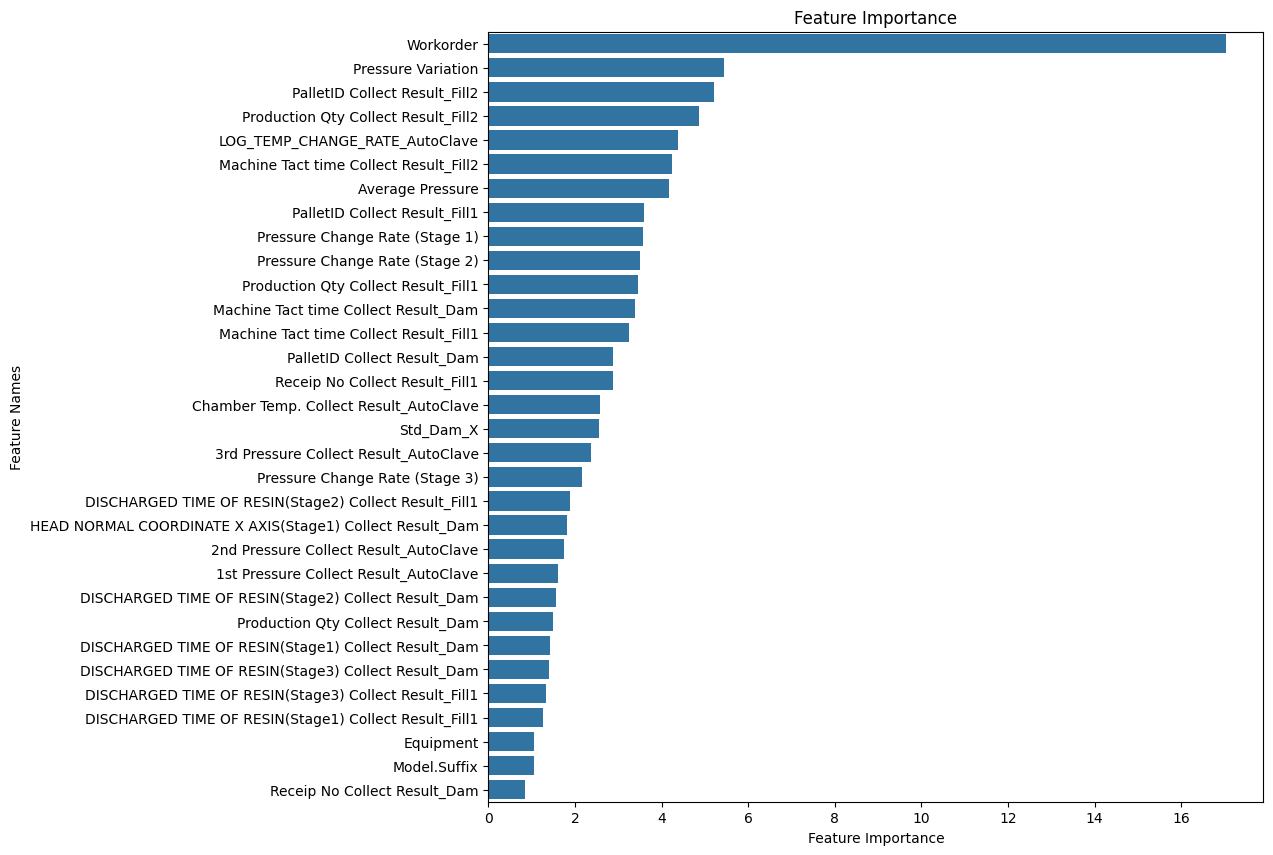

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 10))  # 크기를 조정함
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')
    plt.show()

# 함수 사용 예시
plot_feature_importance(feature_importance_df_important['Importance'], feature_importance_df_important['Feature'])
